<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Introduction to Point Spread Function (PSF) - Part b: science demo </b> <br>
Contact author(s): Andrés A. Plazas Malagón<br>
Last verified to run:  09/5/2023 <br>
LSST Science Pipelines version: w_2023_21  <br>
Container Size: medium <br>
Targeted learning level: advanced <br>

**Description:** Demonstration of the use of PSF catalog properties in weak lensing.

**Skills:** Use of the catalog data products for PSF studies. 

**LSST Data Products:**   DP0.2 collection: `2.2i/runs/DP0.2`. Dataset types: `calexp`, `deepCoadd`.  Catalogs: `dp02_dc2_catalogs.Object`, `dp02_dc2_catalogs.Source`.

**Packages:** lsst.afw.image, lsst.afw.detection, lsst.rsp, lsst.daf.butler, lsst.geom, lsst.afw.display, lsst.analysis.tools

**Credits:** Developed by Andrés A. Plazas Malagón in collaboration with Melissa Graham, Jeff Carlin, Douglas Tucker, Ryan Lau, and the Rubin Community Science Team for DP0.2. The section on PSF size and its correlation function using the `treecorr` software is based on a Jupyter notebook authored by Claire-Alice Hebert. The section on PSF size histograms and their dependency on the central filter wavelength is derived from a Jupyter Notebook by Tianqing Zhang. The section on `rho` statistics using `lsst.analysis.tools` draws from a Jupyter Notebook by Arun Kannawadi.

This notebook incorporates suggestions from the [Accessible Authoring Checklist](https://iota-school.github.io/accessibility_hackathon/hack#checklist) and utilizes NASA's Astrophysics Data System Bibliographic Services.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This tutorial is the second part of tutorial `DP)2_12a_Point_Spread_Function`. It is composed of the following sections:

- Section 1 calculates and displays the size of the PSF in a particular photometric band (`i`) as a function of sky location. It also computes the size-size two-point correlation function (autocorrelation) using the `treecorr` software. This software is widely used in state-of-the-art weak lensing analyses to derive cosmological parameters. These calculations are performed using both `calexp` and `deepCoadd` images.

- Section 2 illustrates one chromatic dependence of the PSF: the wavelength dependence of the PSF size.

- Section 3 calculates the `rho` statistics, a series of two-point correlation functions used to diagnose the quality of a PSF model for weak lensing analyses. This calculation is done using the `lsst.afw.analysis.tools` framework.

#### Additional Resources

Review article: [Point Spread Function Modelling for Astronomical Telescopes: A Review Focused on Weak Gravitational Lensing Studies](https://ui.adsabs.harvard.edu/abs/2023arXiv230607996L/abstract)

[Treecorr Documentation](https://rmjarvis.github.io/TreeCorr/_build/html/index.html)

Chromatic effects of the PSF:

- Impact of Differential Chromatic Refraction (DCR) on weak lensing:  
 [Plazas and Bernstein 2012](https://ui.adsabs.harvard.edu/abs/2012PASP..124.1113P/abstract)
    
- Impact of DCR on Supernovae measurements: 
[Lee et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165..222L/abstract)
    
- Impact of DCR, wavelength dependence of seeing, and other chromatic effects on weak lensing:
[Meyers and Burchat 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...807..182M/abstract)

PSF modeling and null tests for galaxy surveys, including `rho` statistics:

-  [Dark Energy Survey Y3 Results: Point Spread Function Modeling](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract)
-  [The Three-Year Shear Catalog of the Subaru Hyper Suprime-Cam SSP Survey](https://ui.adsabs.harvard.edu/abs/2022PASJ...74..421L/abstract)

PSF in coadded images: 

- [Mandelbaum et al. 2022](https://ui.adsabs.harvard.edu/abs/2023OJAp....6E...5M/abstract)

### 1.1. Package Imports

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), [numpy](http://www.numpy.org/), [scipy](https://scipy.org/), and [astropy](http://www.astropy.org/) libraries are widely used Python libraries for plotting, scientific computing, scientific analysis, and astronomical data analysis.

The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for queries to the DP0 catalogs.

The `lsst.afw.image` provide visualization tools.

The `lsst.afw.display` library provides access to image visualization routines and the `lsst.daf.butler` library is used to access data products via the butler.

The `lsst.afw.analysis.tools` library provides acces to analysis tools.

The `lsst.geom` library provides the representation of a 2D coordinate `Point2D`.

The `lsst.pipe.base` library provides access to the `lsst.pipe.base.Struct` container.

[treecorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html) by [Jarvis et al. 2004](https://ui.adsabs.harvard.edu/abs/2004MNRAS.352..338J/abstract) is a widely used tool for fast correlations measurements based on a ball tree method (similar to a [k-d tree](https://en.wikipedia.org/wiki/K-d_tree)). In particular, it is widely used in state-of-the-art weak lensing cosmological analyses. 

In [1]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import treecorr
from scipy.optimize import curve_fit
from matplotlib import cm
from numpy.linalg import norm
from matplotlib.ticker import LinearLocator
from matplotlib.offsetbox import AnchoredText

import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
from lsst.rsp import get_tap_service
from lsst.geom import Point2D, radToDeg, SpherePoint, degrees
from lsst.analysis.tools.atools import RhoStatistics

### 1.2 Functions and Parameters Definitions

The following cell will set a standard figure size and `afwDisplay` backend to use throughout the notebook.

In [3]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

The following cell defines a power-law function.

In [34]:
def power(lam, a, b):
    return a*lam**(-b)

### 2. Size of the PSF and its correlation function using `treecorr`.

In this section, our focus will be on plotting the size of the `deepCoadd` PSF in the `i` band as a function of celestial coordinates. To achieve this, we will utilize the TAP service to retrieve point sources from the `deepCoadd` catalog, along with the necessary parameters. Once we've calculated the PSF size based on the modeled PSF second moments, we will visualize it with respect to sky coordinates. 

Moreover, we will harness the capabilities of the `treecorr` software to compute the two-point correlation function of the size, considering angular separation as the variable of interest. Two-point correlation functions hold significant importance in weak lensing cosmological analysis, as they allow us to infer crucial cosmological parameters. Notably, `treecorr` serves as the standard tool employed by various collaborations, including the Dark Energy Survey and the Hyper-Suprime Camera Survey. It's also a prominent choice utilized by the LSST Science Pipelines code.

#### 2.1 Cone Search around the DC2 center using the `Object` catalog (`deepCoadd` images).  
Let's conduct a cone search (similar to DP0.2 NB2) centered around the DC2 central point, with a search radius of 2 degrees. The query below utilizes the `Object` catalog, which houses the `deepCoadd` objects (refer to the [DP0.2 schema browser](https://dm.lsst.org/sdm_schemas/browser/dp02.html#Object)). Our query seeks PSF fluxes in various bands, derived from fitting a PSF model to a specific set of stars. We'll utilize the second moments of the PSF, denoted as `{band}_ixxPSF`, `{band}_ixyPSF`, and `{band}_iyyPSF`, to calculate the PSF size for each band.

In this section, our focus is on plotting the PSF size exclusively in one band (`i`). However, in the subsequent section (section 4), we'll illustrate the relationship between PSF size and seeing by employing different bands. To identify point sources, we've set the flags `detect_isPrimary` and `i_extendedness` to 1 and 0.0, respectively. The presence of the `i_calib_psf_used` flag ensures our selection of stars that were utilized (rather than reserved) for establishing the PSF model (refer, for instance, to [Jarvis et al. 2020](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract)).

To ensure that the chosen objects aren't near edges, the `i_pixelFlags_inexact_psfCenter = 0` flag is employed. This choice is influenced by the fact that the `EDGE` flag in a `calexp` corresponds to the `SENSOR_EDGE` flag in the `coadd`. Objects near these edges have a discontinuous PSF. Additionally, the `inexact_psfCenter` results from an `OR` operation that includes `SENSOR_EDGE`. The other properties retrieved through the query will play a role in calculating the `rho` statistics, which will be the subject of section 5 in this notebook.

In [5]:
service = get_tap_service("tap")

In [6]:
use_center_coords = "62, -37"
band = 'i'

The following query could take more than a minute.

In [7]:
results = service.search("SELECT TOP 1000000"
                         "coord_ra, coord_dec, "
                         "scisql_nanojanskyToAbMag(u_psfFlux) as u_psfMag, "
                         "scisql_nanojanskyToAbMag(g_psfFlux) as g_psfMag, "
                         "scisql_nanojanskyToAbMag(r_psfFlux) as r_psfMag, "
                         "scisql_nanojanskyToAbMag(i_psfFlux) as i_psfMag, "
                         f"scisql_nanojanskyToAbMagSigma({band}_psfFlux, "
                         f"{band}_psfFluxErr) "
                         f"as {band}_psfMagErr, "
                         f"{band}_psfFlux, "
                         f"{band}_psfFlux_flag, "
                         f"{band}_pixelFlags_saturatedCenter, "
                         f"{band}_extendedness_flag, "
                         "xy_flag, detect_isPatchInner, "
                         "detect_isDeblendedSource, "
                         f"{band}_psfFluxErr, {band}_extendedness, "
                         f"{band}_ixy, {band}_ixyPSF, "
                         "g_ixx, g_iyy, g_ixxPSF, g_iyyPSF, "
                         "r_ixx, r_iyy, r_ixxPSF, r_iyyPSF, "
                         "i_ixx, i_iyy, i_ixxPSF, i_iyyPSF, "
                         "u_ixx, u_iyy, u_ixxPSF, u_iyyPSF  "
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         "CIRCLE('ICRS', "+use_center_coords+", 2.0)) = 1 "
                         "AND detect_isPrimary = 1 "
                         f"AND {band}_calibFlux > 360 "
                         f"AND {band}_extendedness = 0.0 "
                         f"AND {band}_calib_psf_used = 1 "
                         f"AND {band}_pixelFlags_inexact_psfCenter = 0 ")

results_table = results.to_table().to_pandas()

In [8]:
print(len(results_table))

9964


##### 2.1.1 Size calculation, visualization, and two-point correlation function calculation. 

The trace of the moments matrix in each band, `T = {band}_ixxPSF + {band}_iyyPSF` will be used to calculate the "trace radius" (in pixels) `sqrt(T/2)` of the PSF model in each band, as a mesure of its size. 

In [9]:
results_table['size_g_PSF'] = np.sqrt((results_table['g_ixxPSF']
                                       + results_table['g_iyyPSF']) / 2)
results_table['size_r_PSF'] = np.sqrt((results_table['r_ixxPSF']
                                       + results_table['r_iyyPSF']) / 2)
results_table['size_i_PSF'] = np.sqrt((results_table['i_ixxPSF']
                                       + results_table['i_iyyPSF']) / 2)
results_table['size_u_PSF'] = np.sqrt((results_table['u_ixxPSF']
                                       + results_table['u_iyyPSF']) / 2)

In [10]:
ra = results_table['coord_ra']
dec = results_table['coord_dec']

Use the `treecorr` software ([Jarvis et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ascl.soft08007J/abstract)) to compute the two-point correlation function of the PSF model size as a function of angular separation. 

In a broader sense, the two-point correlation function serves as a statistical metric that aids in comprehending the distribution and potential correlations of random variables within space or time.

In astronomy, this function was introduced as a means to quantify the excess probability of locating two galaxies at a specific distance apart, as opposed to an expected uniform distribution ([Pebbles 1980](https://ui.adsabs.harvard.edu/abs/1980lssu.book.....P/abstract)). 

In modern galaxy surveys such as the Dark Energy Survey (DES), this tool is applied for cross-correlating key quantities like galaxy number counts and weak lensing shear in a "3x2" point analysis. 

This analysis methodology is employed to deduce constraints on cosmological parameters, and it's an approach that will also be adopted by the Legacy Survey of Space and Time (LSST) (refer to [DES Collaboration 2022](https://ui.adsabs.harvard.edu/abs/2022PhRvD.105b3520A/abstract)).

Define `treecorr`'s catalog and adjust a few of its parameters. For more information about `treecorr`, check its [documentation](https://rmjarvis.github.io/TreeCorr/_build/html/index.html). 

In [11]:
cat = treecorr.Catalog(ra=ra, dec=dec,
                       k=results_table[f'size_{band}_PSF']
                       - np.mean(results_table[f'size_{band}_PSF']),
                       ra_units='deg', dec_units='deg')

kk_config = {'max_sep': .06, 'min_sep': .0001, 'nbins': 12}

Calculate the two-point correlation function of the size. 

In this case, this is an auto-correlation (size-size two point correlation):

In [12]:
kk = treecorr.KKCorrelation(kk_config)
kk.process(cat)

Retrieve the correlation function, denoted by `xi`, and the angular separation arrays:

In [13]:
xi = kk.xi
bins = kk.rnom

The figure generated by the following code cell consists of two panels.

The left panel illustrates the PSF size within the investigated circle and band, as a function of declination (ranging from approximately negative 39 to negative 35 degrees) and right ascension (ranging from around 60 to 64 degrees).

The PSF size or trace radius is depicted using a color scale, with values ranging from about 1.68 to 1.78 pixels.

The right panel of the figure showcases the two-point autocorrelation function of the PSF size, plotted against angular separations in degrees. 

The correlation function values are expressed as multiples of 1e4, spanning from negative 1 to 4. 

Angular separations are marked on the abscissa axis, ranging from 0.01 to 2 degrees, and are represented on a logarithmic scale.

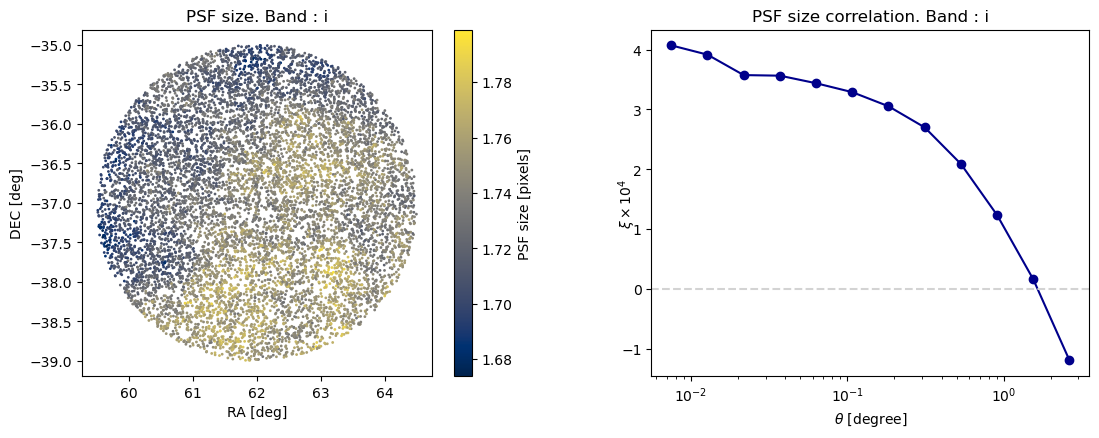

In [14]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5),
                             gridspec_kw={'wspace': .3})

ax1.set_title(f'PSF size. Band : {band}')
scatter_plot = ax1.scatter(ra, dec, c=results_table[f'size_{band}_PSF'],
                           s=1, cmap='cividis')
ax1.set_xlabel('RA [deg]')
ax1.set_ylabel('DEC [deg]')
plt.colorbar(scatter_plot, ax=ax1, label='PSF size [pixels]')

ax2.set_title(f'PSF size correlation. Band : {band}')
ax2.plot(np.degrees(bins), xi*1e4, 'o-', color='darkblue')
ax2.axhline(0, linestyle='--', color='lightgrey')
ax2.set_xscale('log')
ax2.set_ylabel(r'$\xi \times 10^{4}$', labelpad=-12)
ax2.set_xlabel(r'$\theta$ [degree]')

plt.show()

#### 2.2 Cone Search around the DC2 center using the `Source` catalog (`calexp` images). 

Recreate now the PSF size plot and correlation function, as computed in the previous cells. However, this time we will employ PSF models obtained from `calexp` images instead of `deepCoadd` images.

This adjustment will allow the observation of the variation in PSF size within a visit, while still focusing on the `i` band. 

To achieve this, the `Source` catalog will be used and the query will be slightly modified. 

Specifically, only the columns that are relevant in this case will be requested.

The following query can take approximately one minute to finish.

In [15]:
query = """
        SELECT TOP 500000
            coord_ra, coord_dec,
            ixy, ixyPSF,
            ixx, iyy, ixxPSF, iyyPSF
        FROM dp02_dc2_catalogs.Source
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
            CIRCLE('ICRS', %s, 2.0)) = 1
            AND detect_isPrimary = 1
            AND calibFlux > 360
            AND extendedness = 0.0
            AND calib_psf_used = 1
            AND pixelFlags_suspectCenter = 0
            AND band = '%s'
        """ % (use_center_coords, band)

results_source = service.search(query)

results_table_source = results_source.to_table().to_pandas()

##### 1.2.1 Size calculation, visualization, and two-point correlation function calculation.

In [16]:
temp = 0.5*(results_table_source['ixxPSF'] + results_table_source['iyyPSF'])
results_table_source['size_i_PSF'] = np.sqrt(temp)

ra_source = results_table_source['coord_ra']
dec_source = results_table_source['coord_dec']

In [17]:
cat = treecorr.Catalog(ra=ra_source, dec=dec_source,
                       k=results_table_source[f'size_{band}_PSF']
                       - np.mean(results_table_source[f'size_{band}_PSF']),
                       ra_units='deg', dec_units='deg')
kk_config = {'max_sep': .06, 'min_sep': .0001, 'nbins': 12}
kk = treecorr.KKCorrelation(kk_config)
kk.process(cat)
xi_source = kk.xi
bins_source = kk.rnom

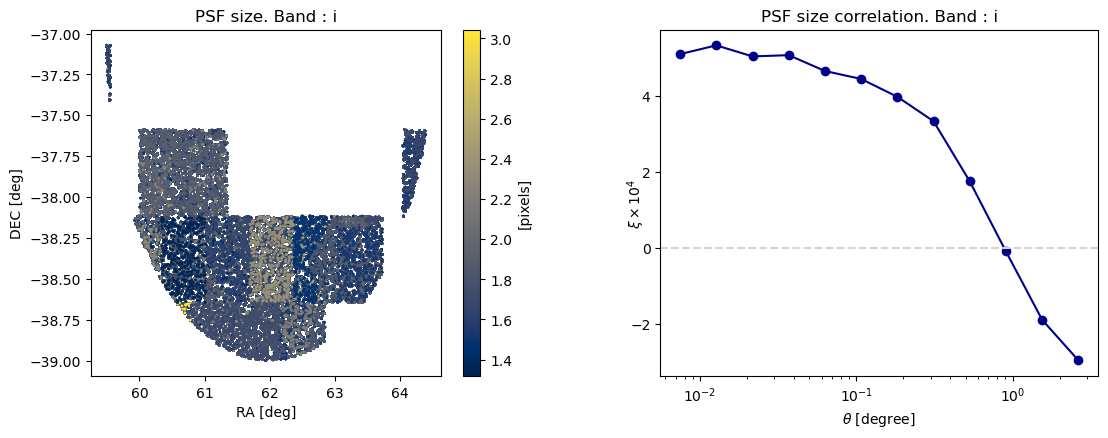

In [18]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5),
                             gridspec_kw={'wspace': .3})

ax1.set_title(f'PSF size. Band : {band}')
scatter_plot = ax1.scatter(ra_source, dec_source,
                           c=results_table_source[f'size_{band}_PSF'],
                           s=1, cmap='cividis')
ax1.set_xlabel('RA [deg]')
ax1.set_ylabel('DEC [deg]')
plt.colorbar(scatter_plot, ax=ax1, label='[pixels]')

ax2.set_title(f'PSF size correlation. Band : {band}')
ax2.plot(np.degrees(bins_source), xi_source*1e4, 'o-', color='darkblue')
ax2.axhline(0, linestyle='--', color='lightgrey')
ax2.set_xscale('log')
ax2.set_ylabel(r'$\xi \times 10^{4}$', labelpad=-12)
ax2.set_xlabel(r'$\theta$ [degree]')

plt.show()

The PSF size exhibits variations at both the tract level and individual visit level. It's important to note that there is no assurance that the sample retrieved from the aforementioned query will be spatially continuous; this may lead to the presence of noticeable gaps in the data.

### 3. Wavelength dependence of seeing  

To correct for the effects of the Point Spread Function (PSF) and to deduce the weak lensing signal (referred to as "shear") from galaxy shapes, the PSF is typically modeled using stars, often bright ones. Subsequently, the PSF of galaxy images is deconvolved by utilizing the estimated PSF convolution kernel. Implicit in this methodology is the assumption that the convolution kernel for galaxies remains the same as that for stars. However, this assumption becomes invalid if the PSF varies with wavelength due to the distinctive Spectral Energy Distributions (SEDs) of stars and galaxies, resulting in disparate PSFs.

In this section, we will leverage the point source sample derived from the `Object` catalog, which was obtained in the preceding sections. Our goal is to compute one of the wavelength-dependent components contributing to the PSF owing to atmospheric effects: the wavelength dependence on seeing. As per the standard theory of atmospheric turbulence, the linear dimension `θ` of the atmospheric convolution kernel (i.e., seeing) is inversely proportional to the wavelength, expressed as $\theta \propto \lambda^{-\frac{1}{5}}$.

Additional wavelength-dependent contributions to the PSF encompass Differential Chromatic Refraction (DCR), telescope diffraction, variations in the absorption length of camera CCDs, and optical chromatic aberrations. In general, each of these factors exhibits distinct functional wavelength dependencies and may exert dominance in different spectral bands. Nevertheless, the wavelength-dependent seeing that we explore in this section tends to be the primary contributor to the PSF. These chromatic PSF effects introduce biases in observables such as photometry, astrometry, measurements of galaxy shape and size, and higher-order moments of the PSF. Addressing these effects is imperative for precise cosmological analysis employing weak gravitational lensing. For more detailed information, refer to the works of [Plazas and Bernstein 2012](https://ui.adsabs.harvard.edu/abs/2012PASP..124.1113P/abstract), [Lee et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165..222L/abstract), [Meyers and Burchat 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...807..182M/abstract), [Tianqing et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.520.2328Z/abstract), and [Meyers and Burchat 2015b](https://ui.adsabs.harvard.edu/abs/2015JInst..10C6004M/abstract).


To replicate this wavelength relationship using our data, we will initiate the process by computing the central wavelengths of the broadband filters employed by LSST, alongside determining the mean size and its standard deviation for each respective band. The boundaries of the filters are available in Table 2.1 of the [LSST Science Book](https://ui.adsabs.harvard.edu/abs/2009arXiv0912.0201L/abstract).

In [19]:
wavelength = 0.5*np.array([320+400, 400+552, 552+691, 691+818])

mean_size = [np.mean(results_table['size_u_PSF']),
             np.mean(results_table['size_g_PSF']),
             np.mean(results_table['size_r_PSF']),
             np.mean(results_table['size_i_PSF'])]

std_size = [np.std(results_table['size_u_PSF']),
            np.std(results_table['size_g_PSF']),
            np.std(results_table['size_r_PSF']),
            np.std(results_table['size_i_PSF'])]

We will proceed to fit a power law to the mean PSF size in relation to wavelength by employing [`scipy.optimize.curvefit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). This function takes the functional form to be fitted as its first argument, followed by two arrays containing the data. The output is a tuple consisting of the optimized parameters that minimize the squared residuals of the function with respect to the measured data, labeled as `popt`. Additionally, it provides the estimated 2D covariance matrix of the fitted parameters, denoted as `pcov`, wherein the diagonal elements offer an estimation of their respective one-standard-deviation errors (for more comprehensive information, refer to [the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)).

In [20]:
popt, pcov = curve_fit(power, wavelength, mean_size)
perr = np.sqrt(np.diag(pcov))

In [21]:
lamb_grid = np.arange(300, 800, 1)
fit_size = power(lamb_grid, *popt)
amplitude, exponent = popt
amplitude_error, exponent_error = perr
print(f"Amplitude: {amplitude:.3} +/- {amplitude_error:.3}")
print(f"Exponent: {exponent:.3} +/- {exponent_error:.3}")

Amplitude: 6.32 +/- 0.93
Exponent: 0.196 +/- 0.0235


The fitted exponent, `-0.196 +/- 0.0235` is within one-sigma of the expected value of `-1/5=-0.2`. 

The upcoming code cell will generate a plot depicting the mean PSF size (expressed as the trace radius in pixels) in relation to the central wavelength for the previously specified LSST filters. Additionally, a power law fit will be presented on the same plot, with the associated amplitude and fitting parameters indicated within the legend.

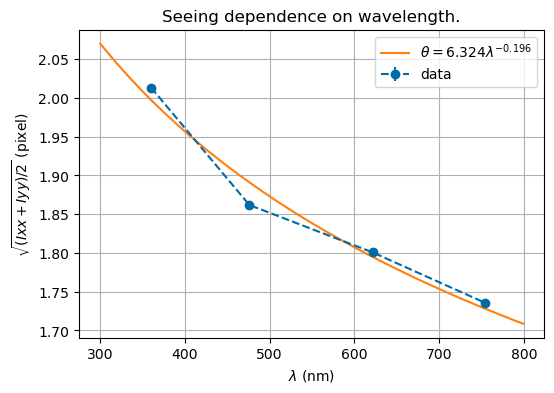

In [22]:
plt.figure(figsize=(6, 4))
plt.errorbar(wavelength, mean_size, std_size/np.sqrt(len(results_table)),
             fmt='o--', label='data')
plt.plot(lamb_grid, fit_size,
         label=r'$\theta = %.3f \lambda^{-%.3f}$' % (amplitude, exponent))
plt.title("Seeing dependence on wavelength.")
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel(r'$\sqrt{(Ixx+Iyy)/2}$ (pixel)')
plt.grid()
plt.legend()
plt.show()

In the forthcoming figure, superimpose the size distributions per band onto the previously generated plot. The figure includes histograms of the size distributions corresponding to each band (`u`, `g`, `r`, and `i`), rotated 270 degrees to align their bases with the left vertical axis. The upper horizontal axis will display the histogram counts, spanning from 0 to approximately 1200 counts. Notably, this plot serves a dual role, as it incorporates both the data for the PSF size as a function of wavelength and the power-law fit from the preceding plot.

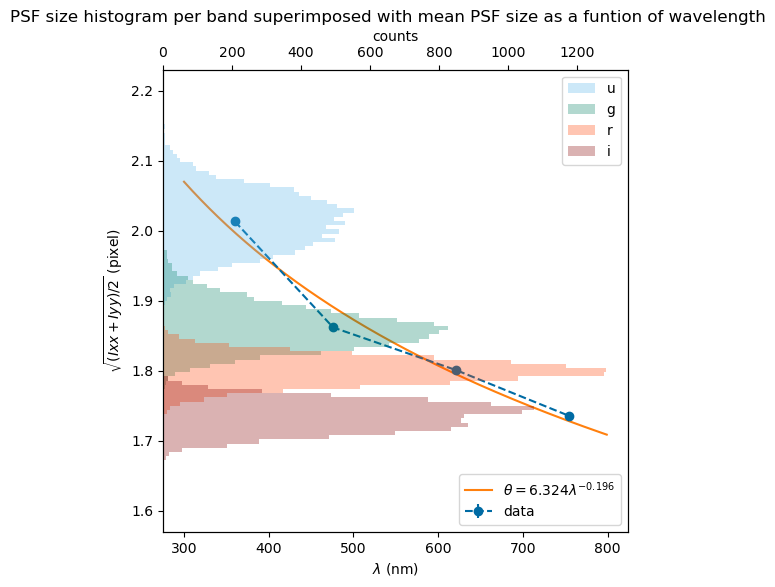

In [23]:
fig, ax1 = plt.subplots(figsize=(6, 6))

color = 'tab:red'
ax1.set_xlabel(r'$\lambda$ (nm)')
ax1.set_ylabel(r'$\sqrt{(Ixx+Iyy)/2}$ (pixel)')
ax1.errorbar(wavelength, mean_size, std_size/np.sqrt(len(results_table)),
             fmt='o--', label='data')
ax1.plot(lamb_grid, fit_size,
         label=r'$\theta = %.3f \lambda^{-%.3f}$' % (amplitude, exponent))
ax1.legend(loc='lower right')
ax1.tick_params(axis='y')

ax2 = ax1.twiny()

plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}

ax2.set_xlabel('counts')
plt.hist(results_table['size_u_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['u'], alpha=0.3, label='u',
         orientation="horizontal")
plt.hist(results_table['size_g_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['g'], alpha=0.3, label='g',
         orientation="horizontal")
plt.hist(results_table['size_r_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['r'], alpha=0.3, label='r',
         orientation="horizontal")
plt.hist(results_table['size_i_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['i'], alpha=0.3, label='i',
         orientation="horizontal")
plt.legend()
ax2.tick_params(axis='y')

fig.suptitle("PSF size histogram per band superimposed with "
             "mean PSF size as a funtion of wavelength")
plt.show()

### 4. Rho Statistics with Analysis Tools

In this section, we will utilize [`lsst.analysis.tools`](https://github.com/lsst/analysis_tools) to compute the `rho` statistics, which are a collection of two-point correlation functions used to assess the spatial relationships between errors in PSF models. The presence of non-zero values in these statistics signifies the existence of systematic errors in the weak lensing shear correlation function. To understand their definitions, refer to [the analysis tools documentation](https://pipelines.lsst.io/v/daily/py-api/lsst.analysis.tools.actions.vector.CalcRhoStatistics.html#lsst.analysis.tools.actions.vector.CalcRhoStatistics). 

`lsst.analysis.tools` is a package designed to generate quality assurance (QA) plots and metrics from the outputs of the LSST Science Pipelines. It employs `treecorr` to compute the `rho` statistics. For an introductory demonstration of `analysis_tools`, you can refer to [this Jupyter Notebook created for a session during Rubin's 2022 Project and Community Workshop](https://github.com/lsst-dm/analysis_tools_examples/blob/main/analysis_tools_demo_pcw2022.ipynb).

We will begin by creating the `RhoStatistics` analysis structure using the `AnalysisTool`. As outlined in the [2022 Rubin PCW `analysis_tools` demo notebook](https://github.com/lsst-dm/analysis_tools_examples/blob/main/analysis_tools_demo_pcw2022.ipynb), the `AnalysisTool` is one of the three analysis structures provided by `analysis_tools`. It encompasses several `AnalysisAction` components, which collectively conduct specific types of analyses.

In [24]:
atool = RhoStatistics()

There are three types of `AnalysisAction`s or stages: `prep` (for initial filtering of data), `process` (for modyfing the data), and `produce` (for generating final plots of metrics). In the following cells, we will adjust a few configuration parameters from the `prep` and `process` stages.

We'll start with selecting stars with with signal-to-noise ratio (SNR) > 20.

In [25]:
atool.prep.selectors.snSelector.threshold = 20.0

As in a previous section, we can adjust the `treecorr` parameters before calculations, but this time it will be done via `lsst.analysis.tools`.

In [26]:
atool.process.calculateActions.rho.treecorr.nbins = 21
atool.process.calculateActions.rho.treecorr.min_sep = 0.1
atool.process.calculateActions.rho.treecorr.max_sep = 100.0

We need to call `atool.finalize()` after the `atool.prep` and `atool.process` stages are configured.


In [27]:
atool.finalize()

The TAP query in section 3.1 included fields that we did not use in that section, but that will be used in this section. In order to know which entries will be needed by `analysys_tools` to calculate the `rho` statistics, we can look at the input schema of the analysis tool `RhoStatistics`.

In [28]:
input_schema = atool.getInputSchema()
needed_catalog_fields = [name[0] for name in list(atool.getInputSchema())]
print(needed_catalog_fields)

['coord_ra', 'coord_dec', '{band}_ixx', '{band}_iyy', '{band}_ixy', '{band}_ixxPSF', '{band}_iyyPSF', '{band}_ixyPSF', '{band}_psfFlux_flag', '{band}_pixelFlags_saturatedCenter', '{band}_extendedness_flag', 'xy_flag', 'detect_isPatchInner', 'detect_isDeblendedSource', '{band}_psfFlux', '{band}_psfFluxErr', '{band}_extendedness']


Now we are ready to compute the `rho` statistics in the particular band that we have chosen previously (`i`).


We'll start with the `prep` stage in the following cell.

In [29]:
prepResults = atool.prep(results_table, band=f"{band}")


Now we will execute the `process` stage, utilizing the outcomes obtained from the `prep` stage:

In [30]:
processResults = atool.process(prepResults, band=f"{band}")

We can now access the results from `treecorr` for each `rho` statistic in order to examine the values or perform any other operation on them.

In [31]:
print("Mean angular separation:\n", processResults['rho1'].meanr, "\n")
print("Correlation function:\n", processResults['rho1'].xip, "\n")
print("Error in the correlation function:\n", processResults['rho1'].varxip)

Mean angular separation:
 [ 0.12017311  0.1685459   0.23266689  0.32544924  0.44883092  0.62813329
  0.86999208  1.20282896  1.67413031  2.3241002   3.23514482  4.49575909
  6.24488969  8.68315973 12.06400542 16.75441258 23.27609725 32.32357124
 44.88376034 62.2863356  86.25761076] 

Correlation function:
 [-2.52355611e-08  3.59581080e-08  1.78502793e-07 -1.85312869e-08
  1.66952141e-07 -1.09300796e-08  7.95629725e-08  1.95907801e-08
  3.46863274e-08  3.19546135e-08  3.72980681e-08  2.96129858e-08
  2.57193076e-08  4.17031265e-08  2.97849672e-08  3.48310519e-08
  2.87107672e-08  3.61937402e-08  3.44089845e-08  3.52376734e-08
  3.36781249e-08] 

Error in the correlation function:
 [1.61385534e-13 9.82346730e-14 5.05835257e-14 2.84798002e-14
 1.40626399e-14 7.22621795e-15 3.91350603e-15 2.03549322e-15
 1.08277834e-15 5.62739098e-16 2.95487704e-16 1.55025786e-16
 8.06553200e-17 4.24496633e-17 2.23005002e-17 1.18095412e-17
 6.35893513e-18 3.48539955e-18 1.96744389e-18 1.15570814e-18
 7.352

Let's now plot the `rho` statistics using `analysis_tools`: 

By default, the rho statistics are plotted on a symmetric log scale.
The threshold where the switch happens from linear to log scale can be set as follows.

In [32]:
atool.produce.plot.rhoPlots["rho3"].yLinThresh = 1e-8

The following cell will produce six plots of the `rho` statistics. For other possible configuration options, you can refer to the documentation [here](https://pipelines.lsst.io/v/daily/py-api/lsst.analysis.tools.actions.plot.XYPlot.html#lsst.analysis.tools.actions.plot.XYPlot). 

The vertical axis of each plot displays the specific `rho` statistic, and the horizontal axis represents the separation in arcminutes, ranging from approximately 0.1 to 100 arcminutes on a logarithmic scale.

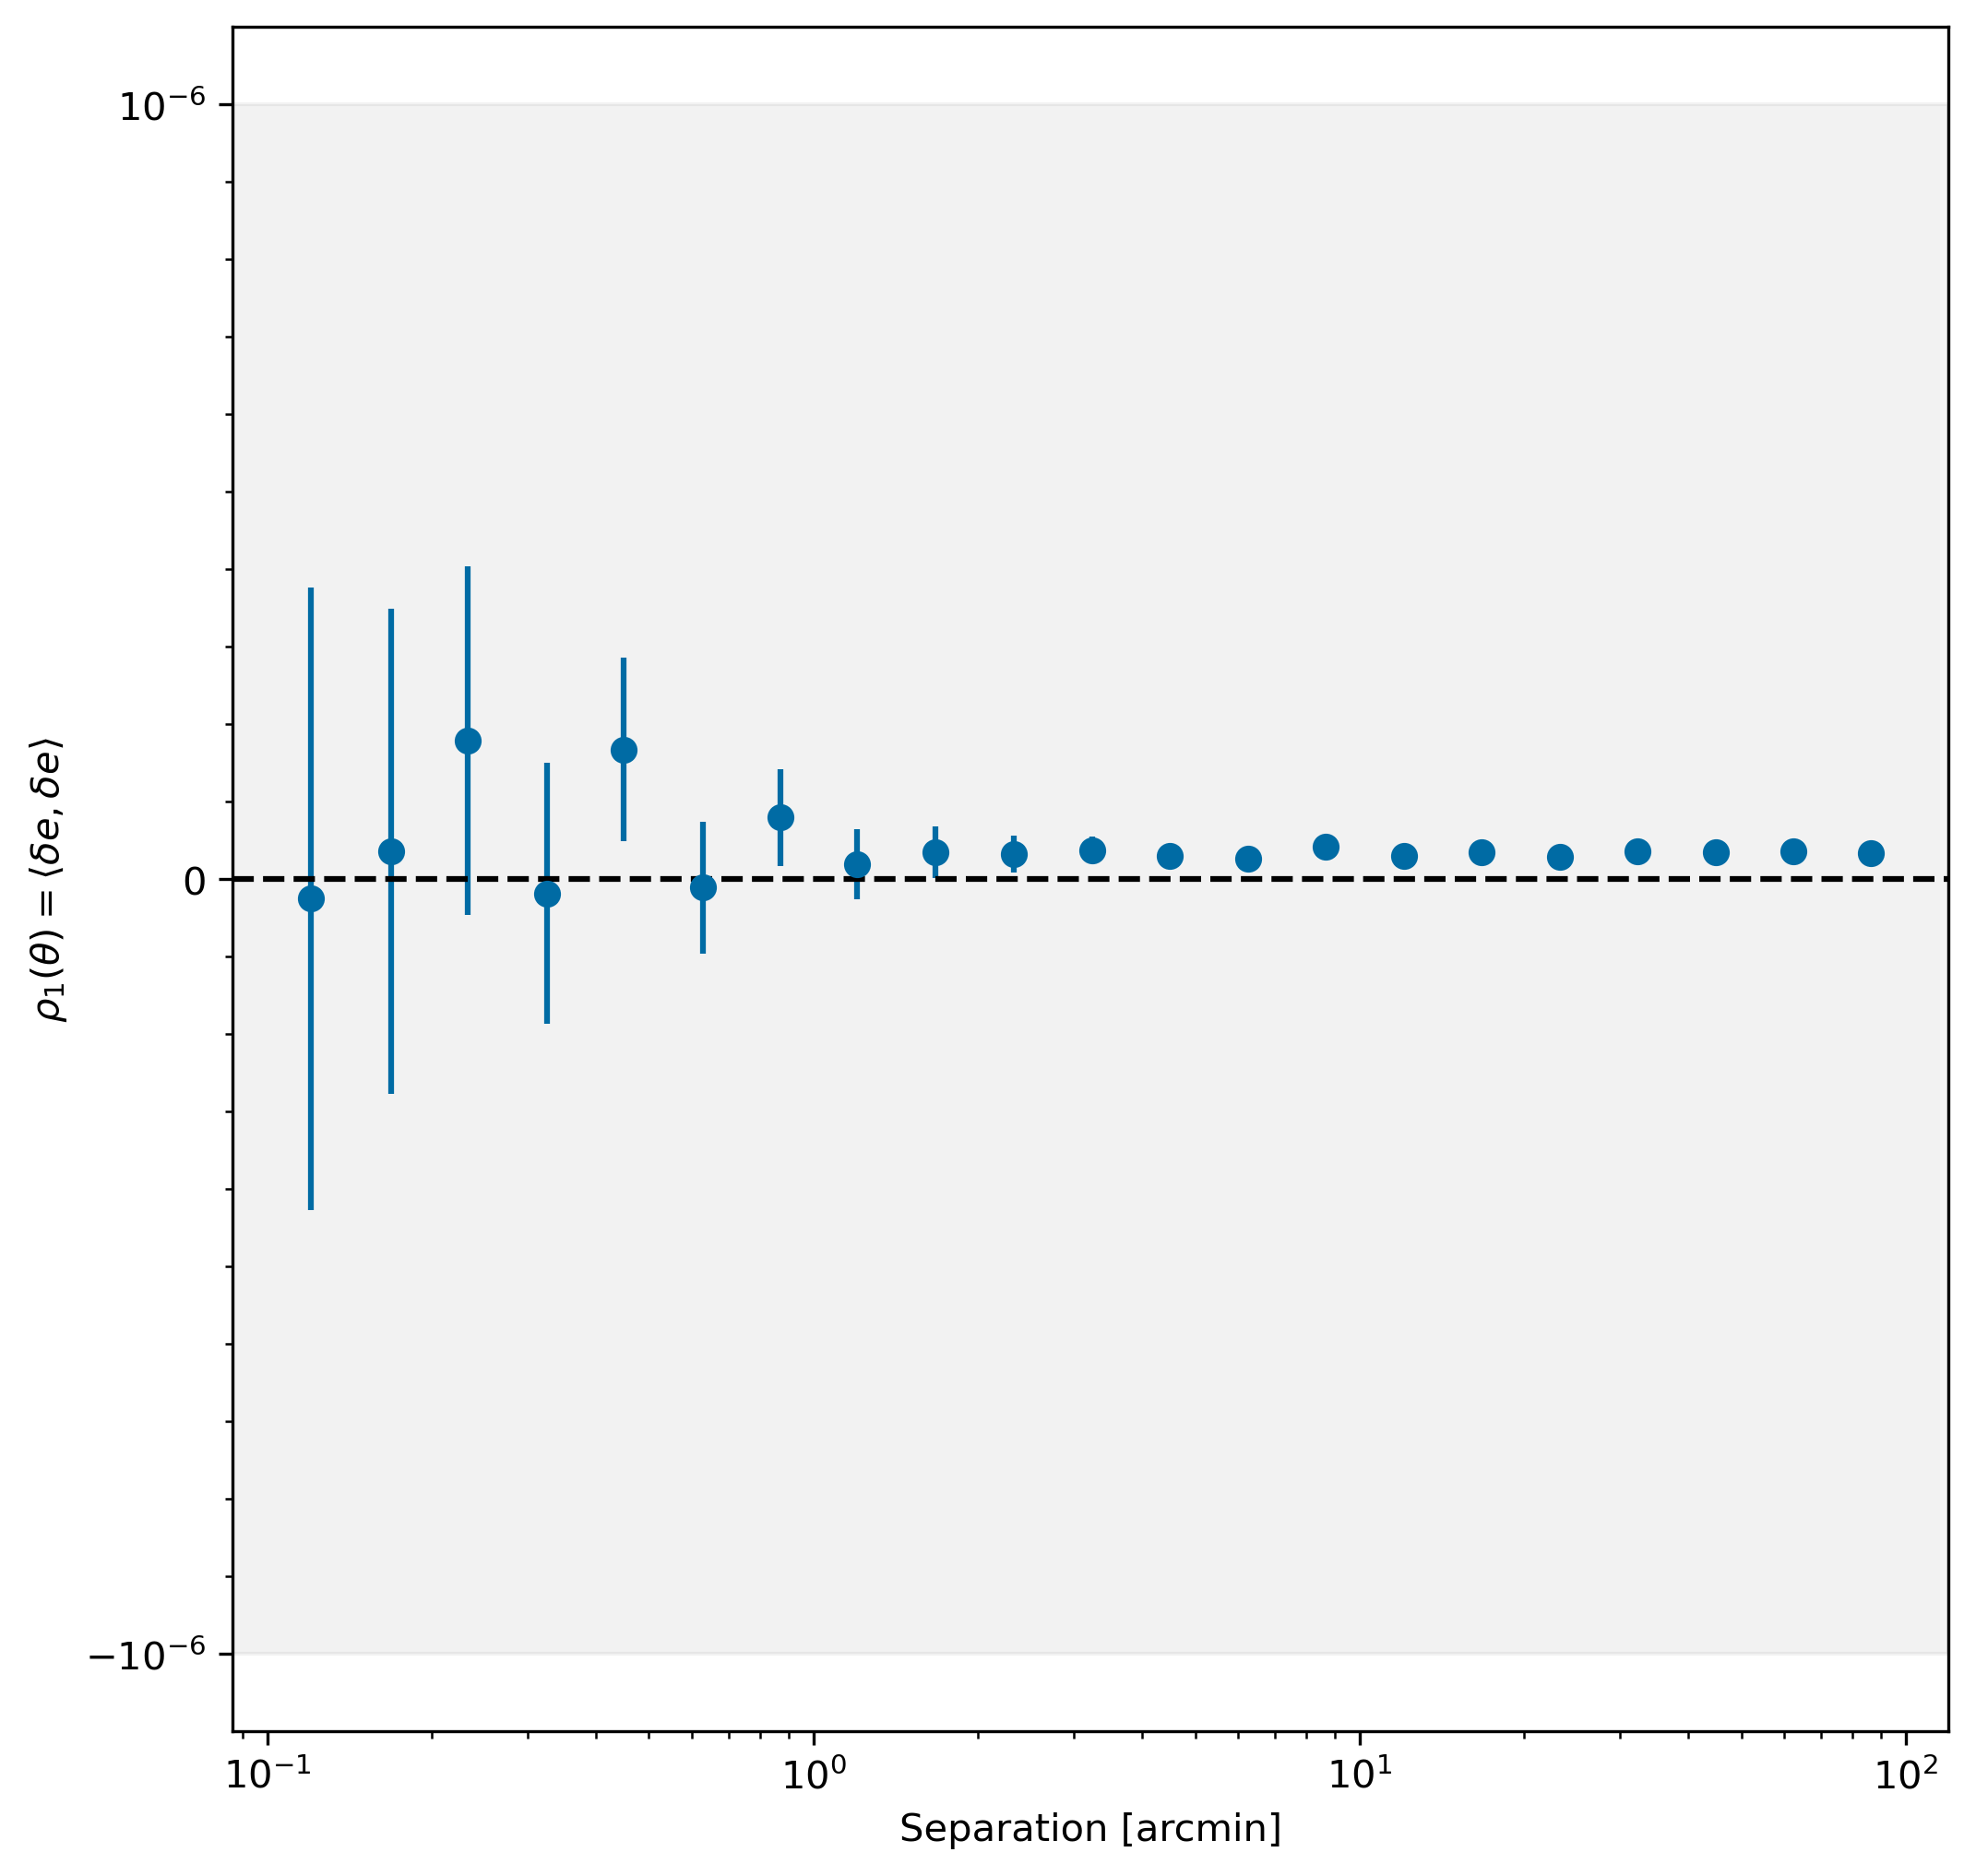

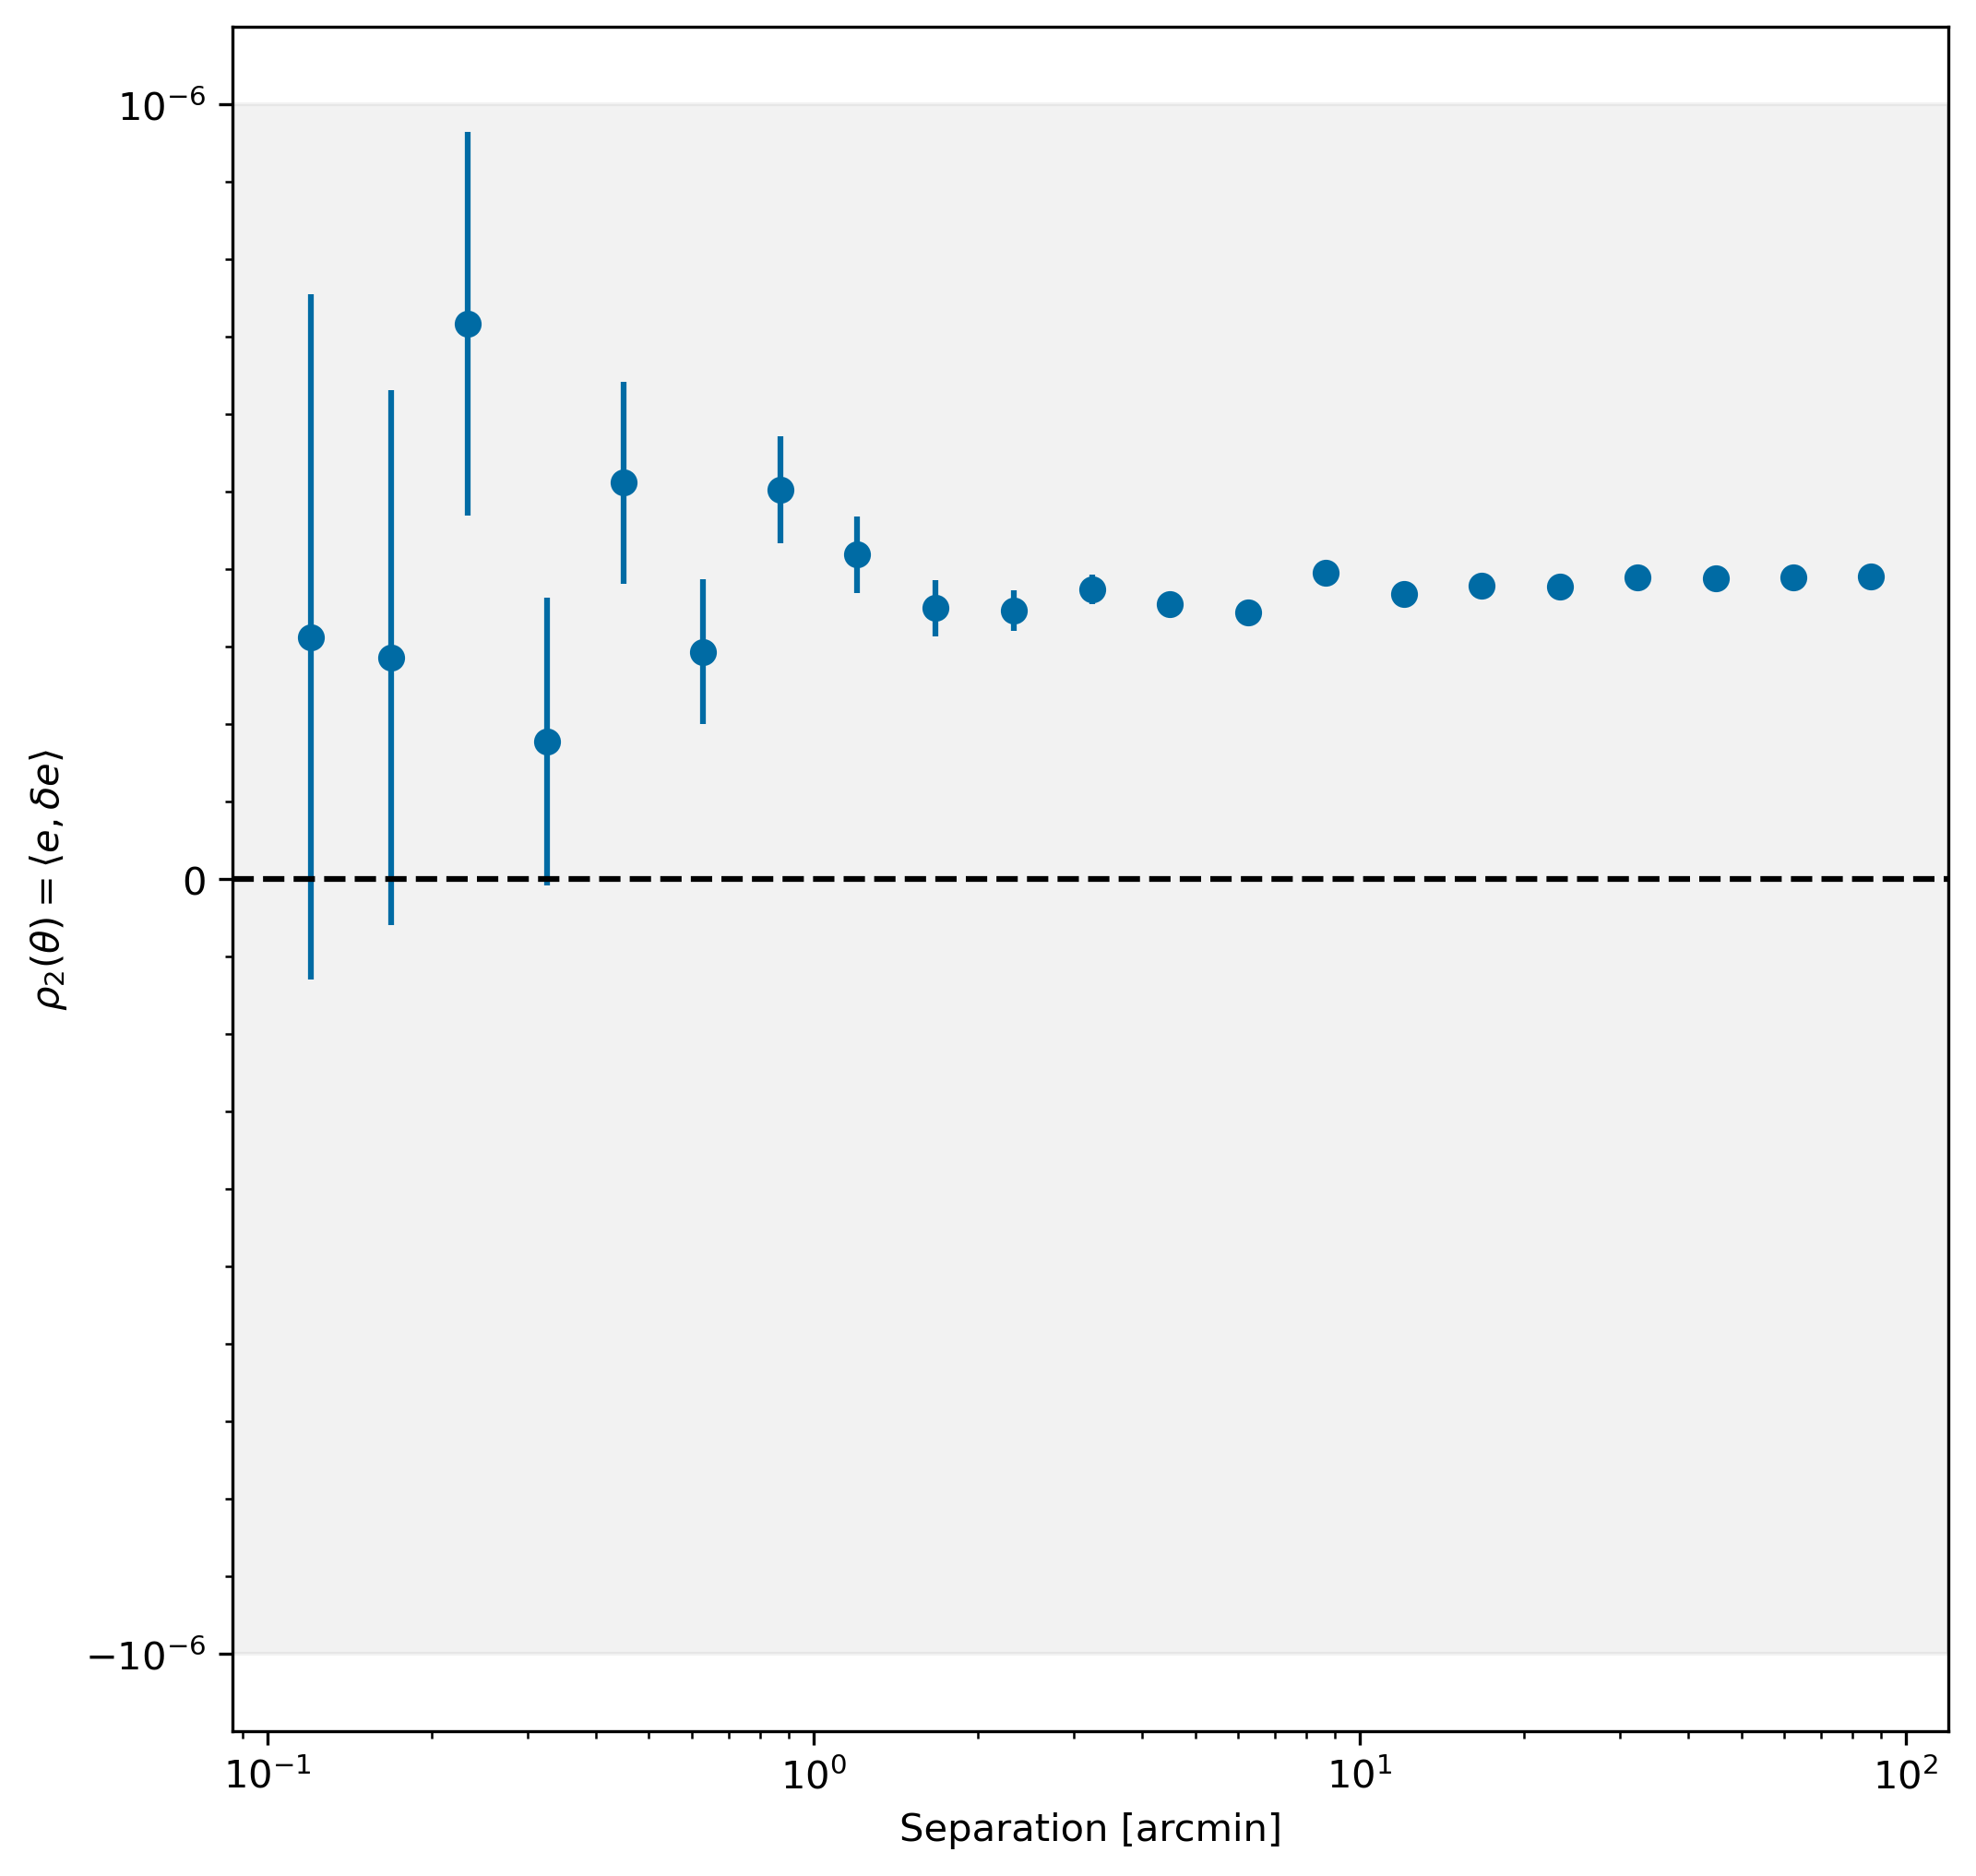

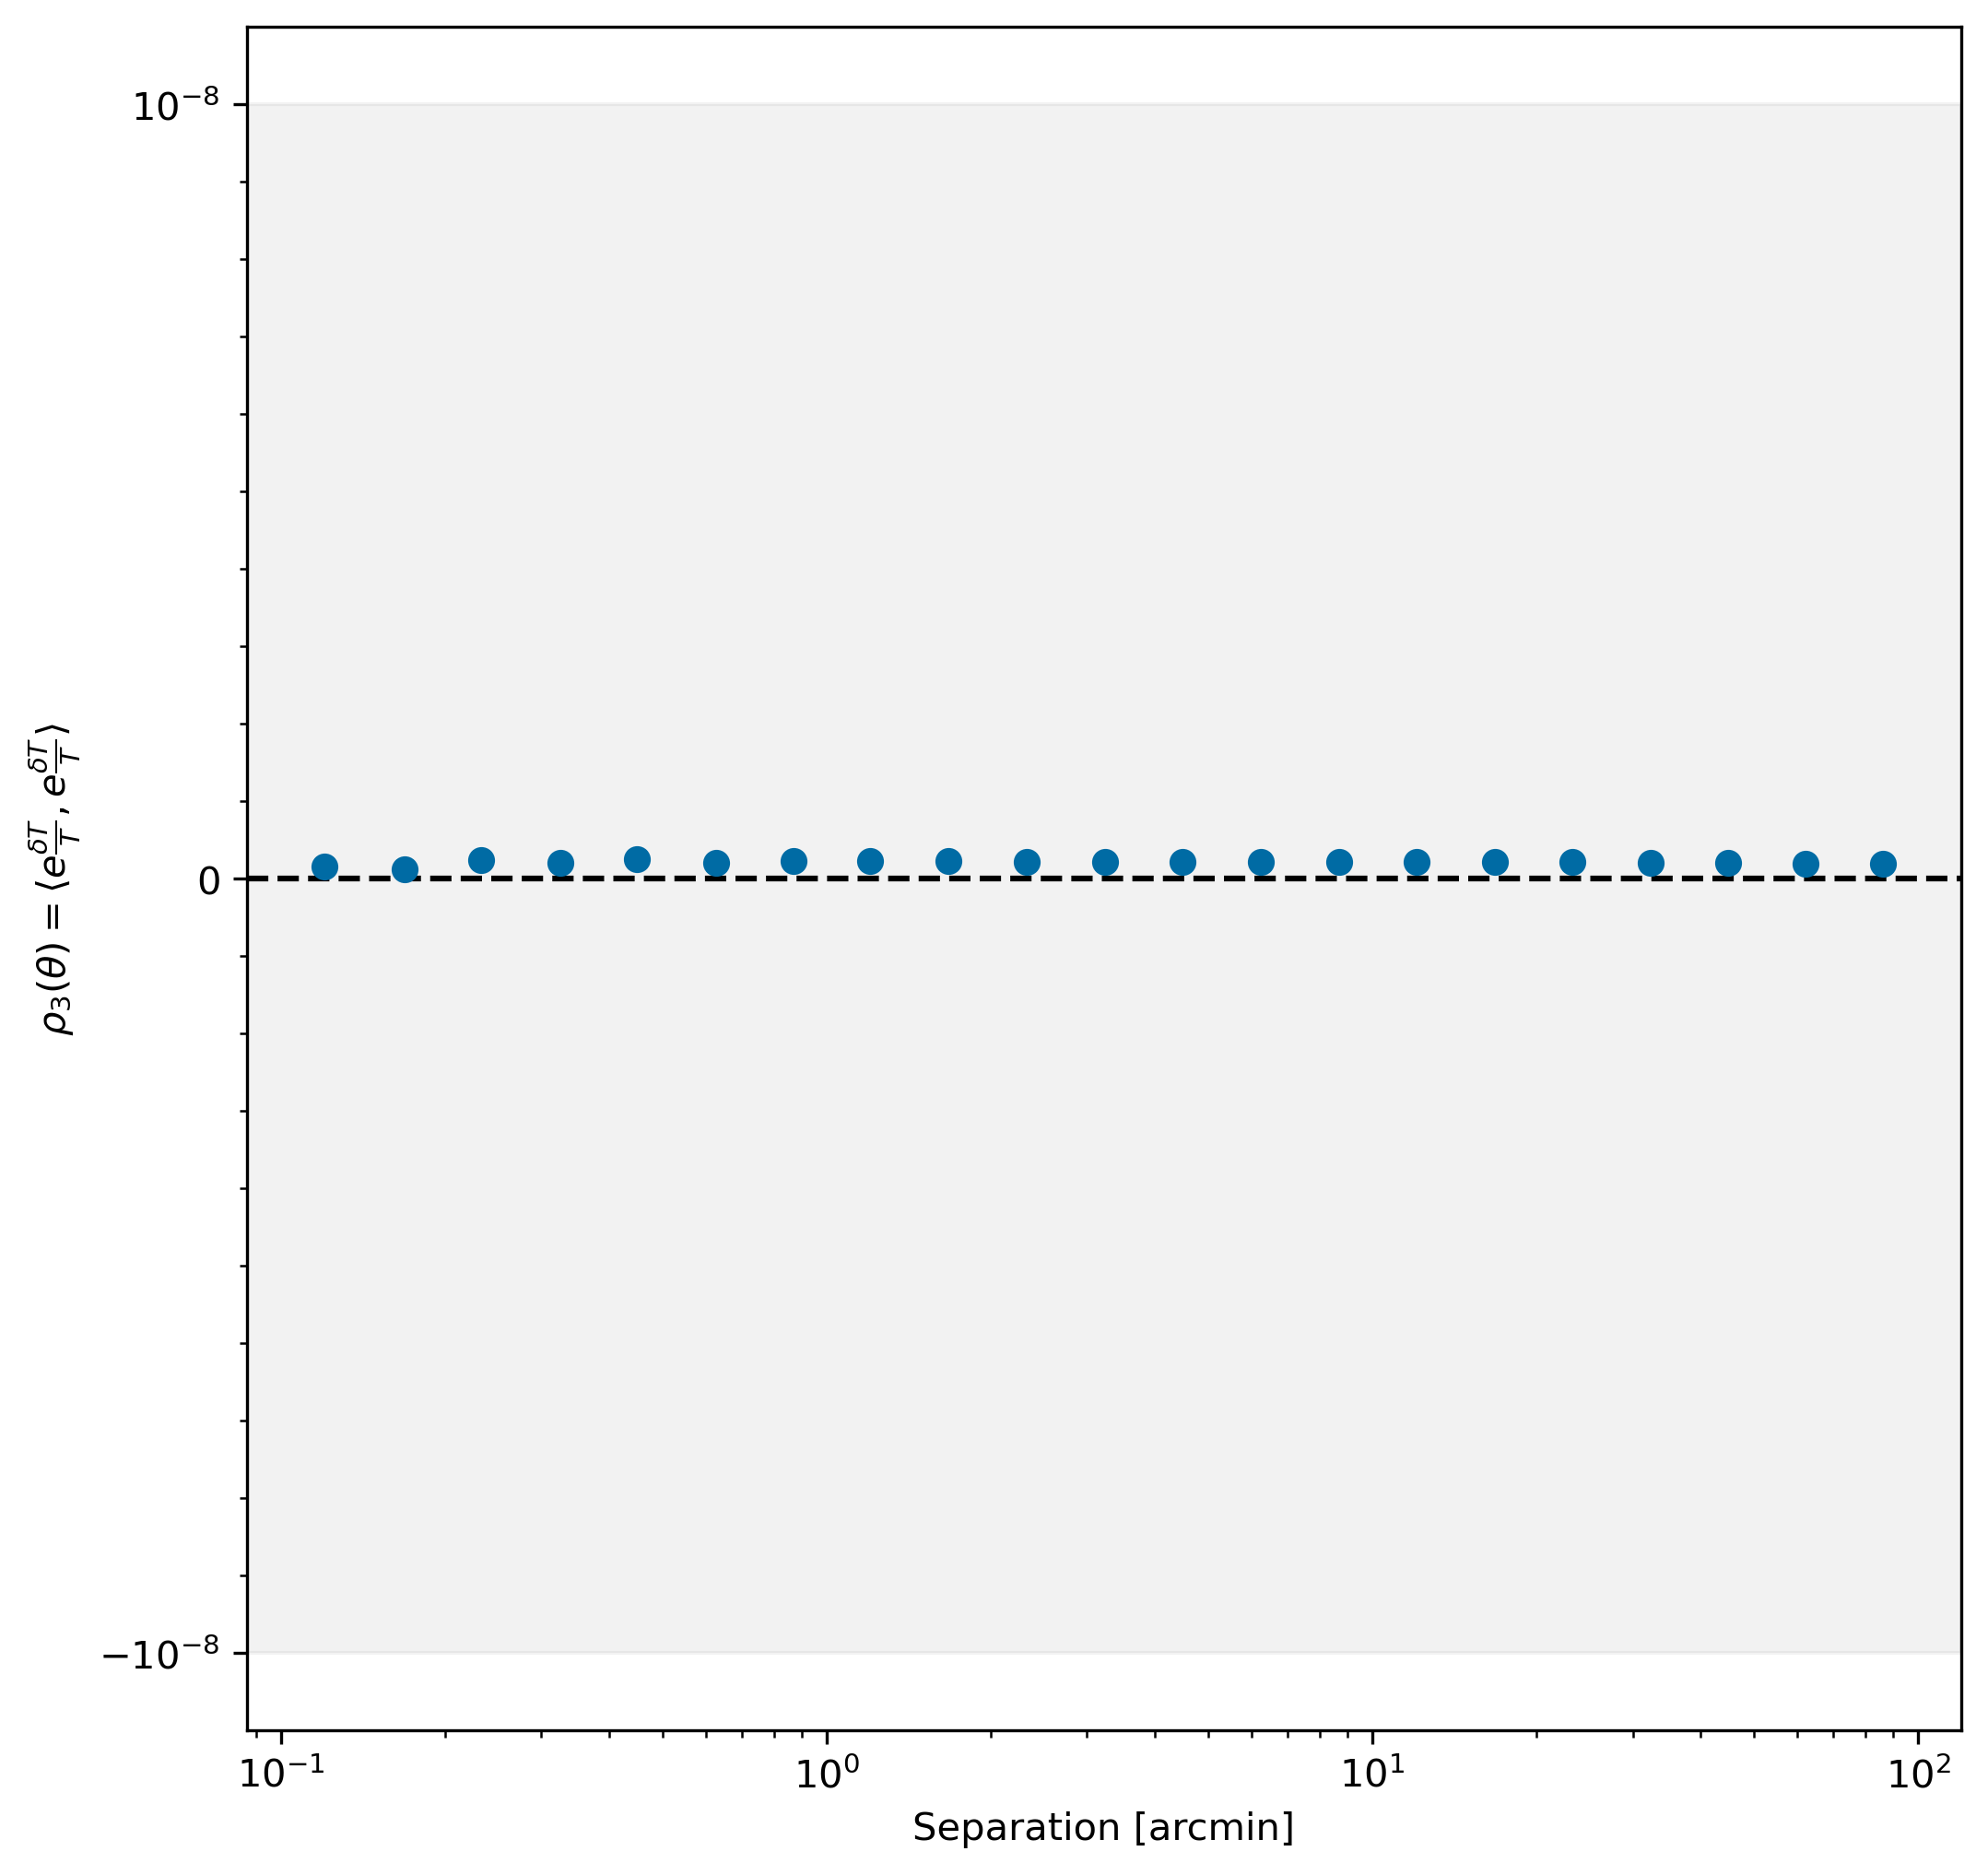

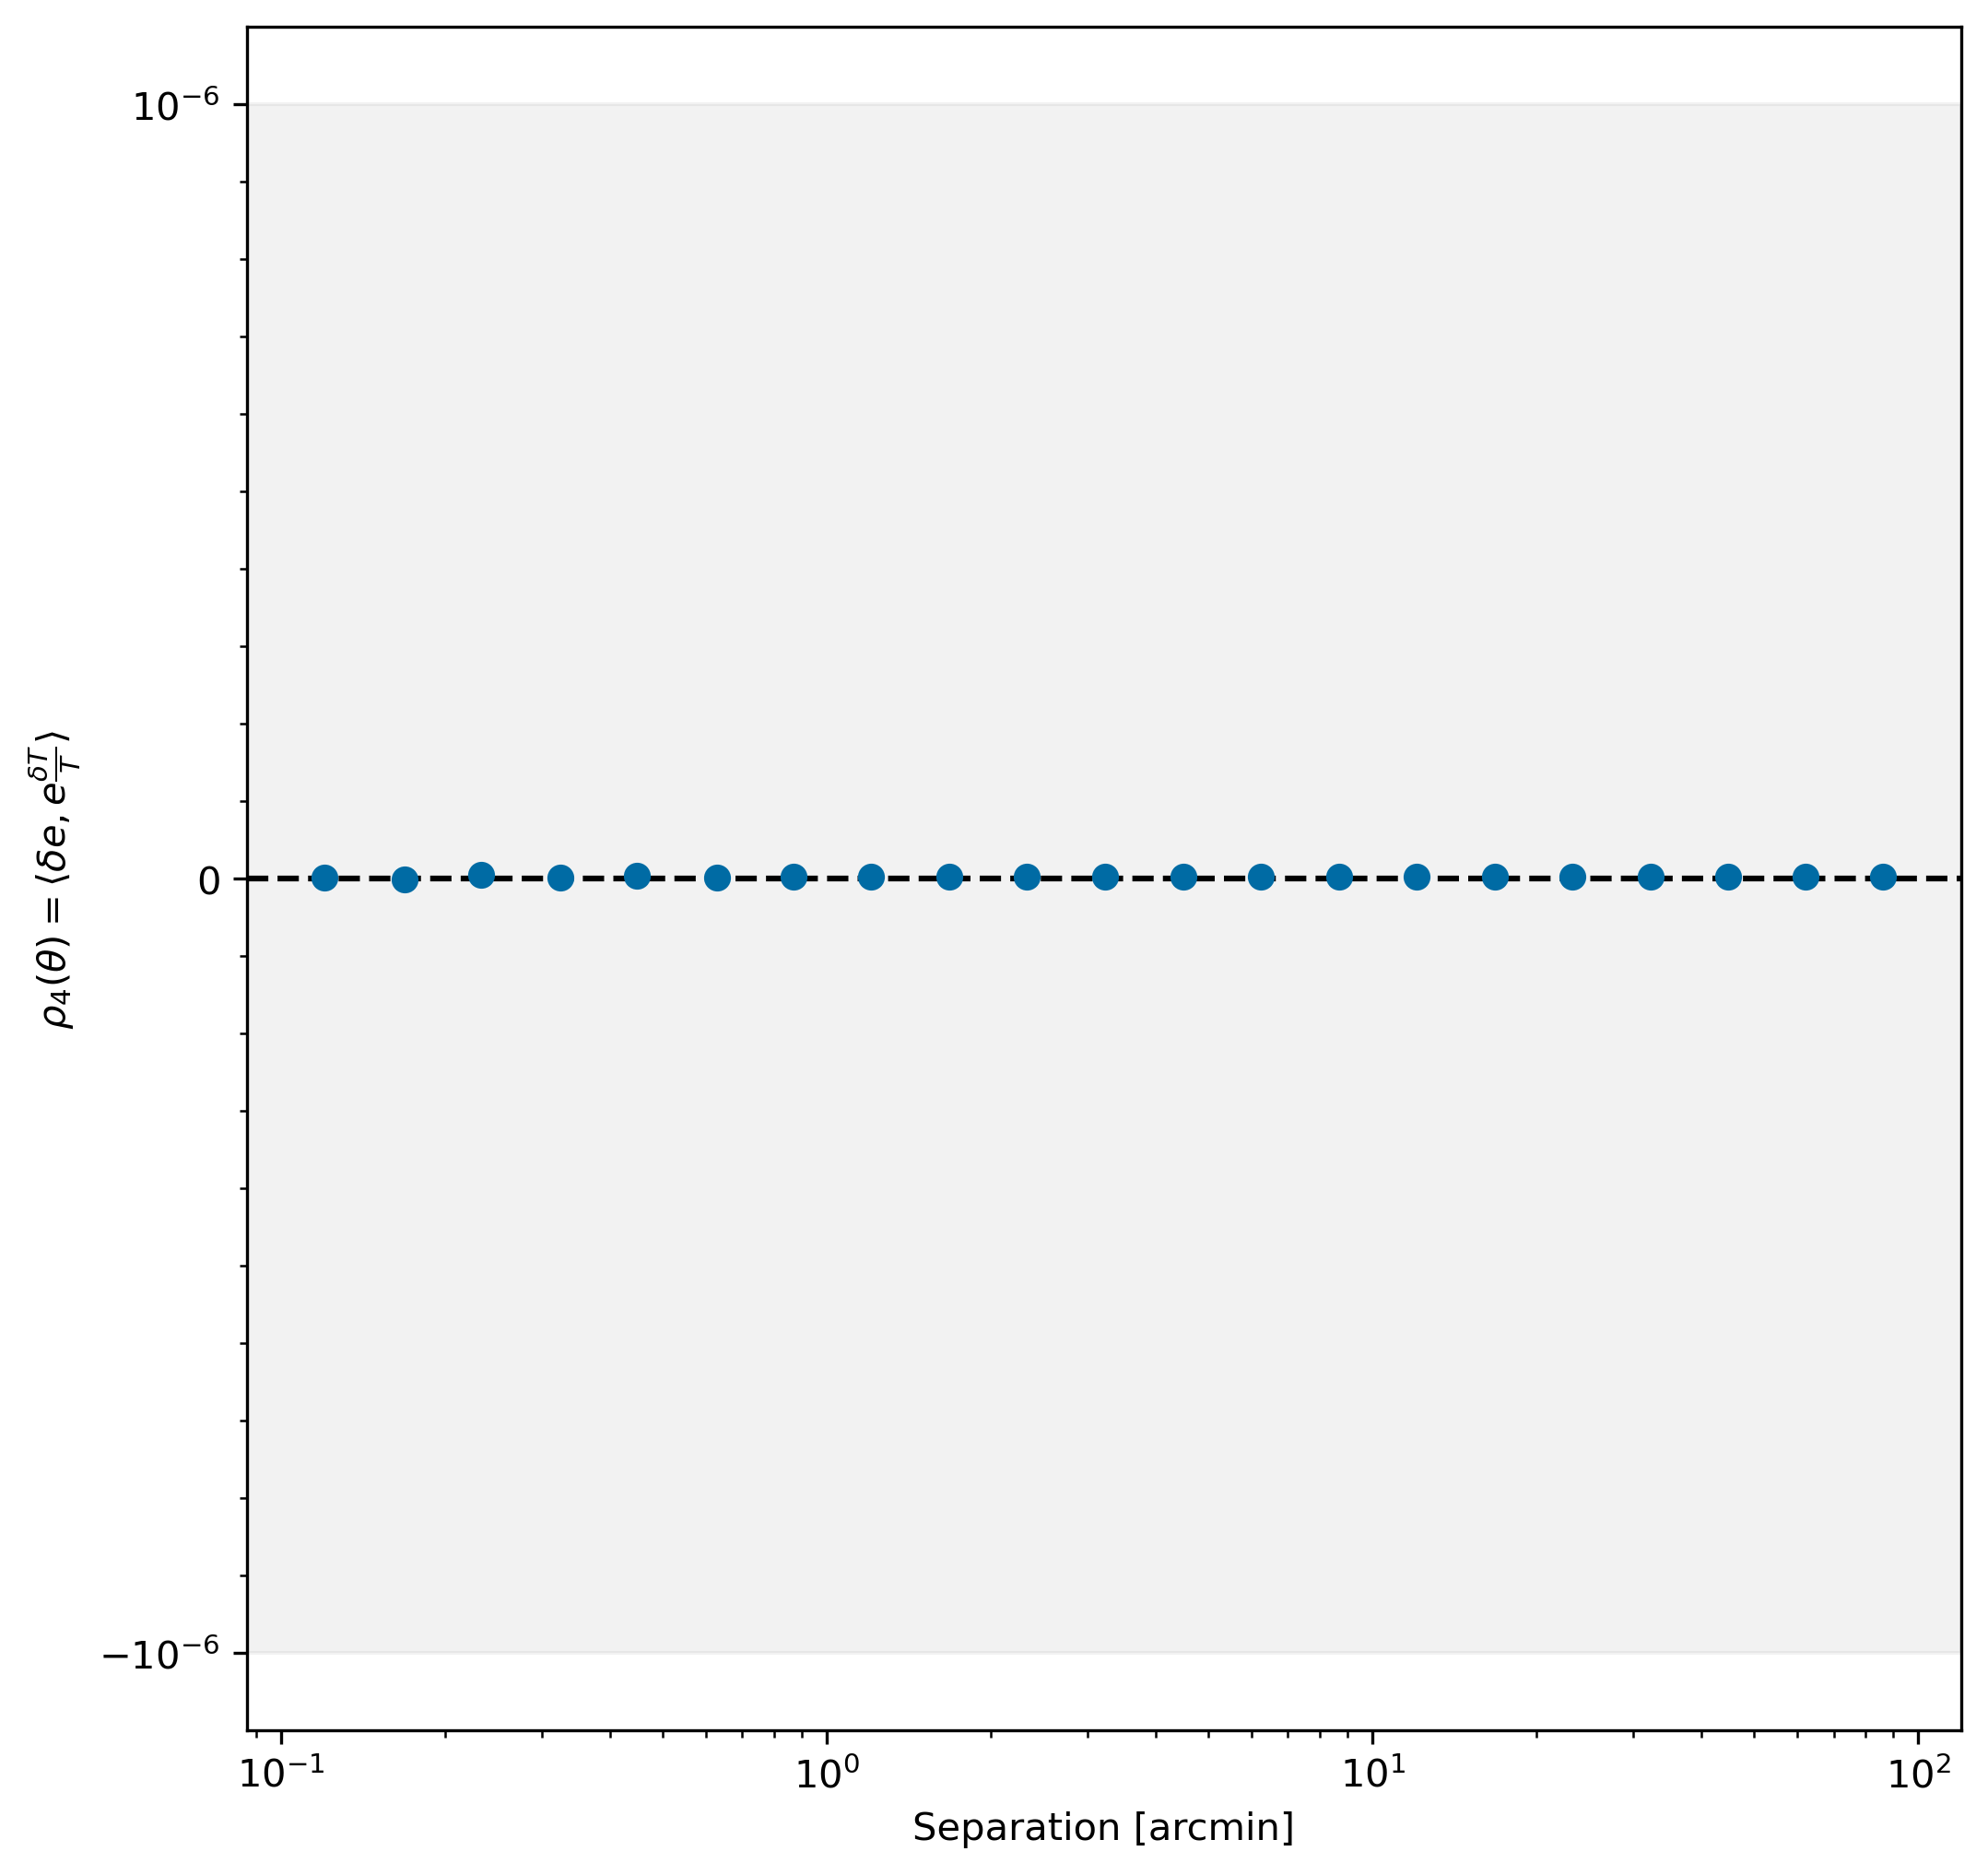

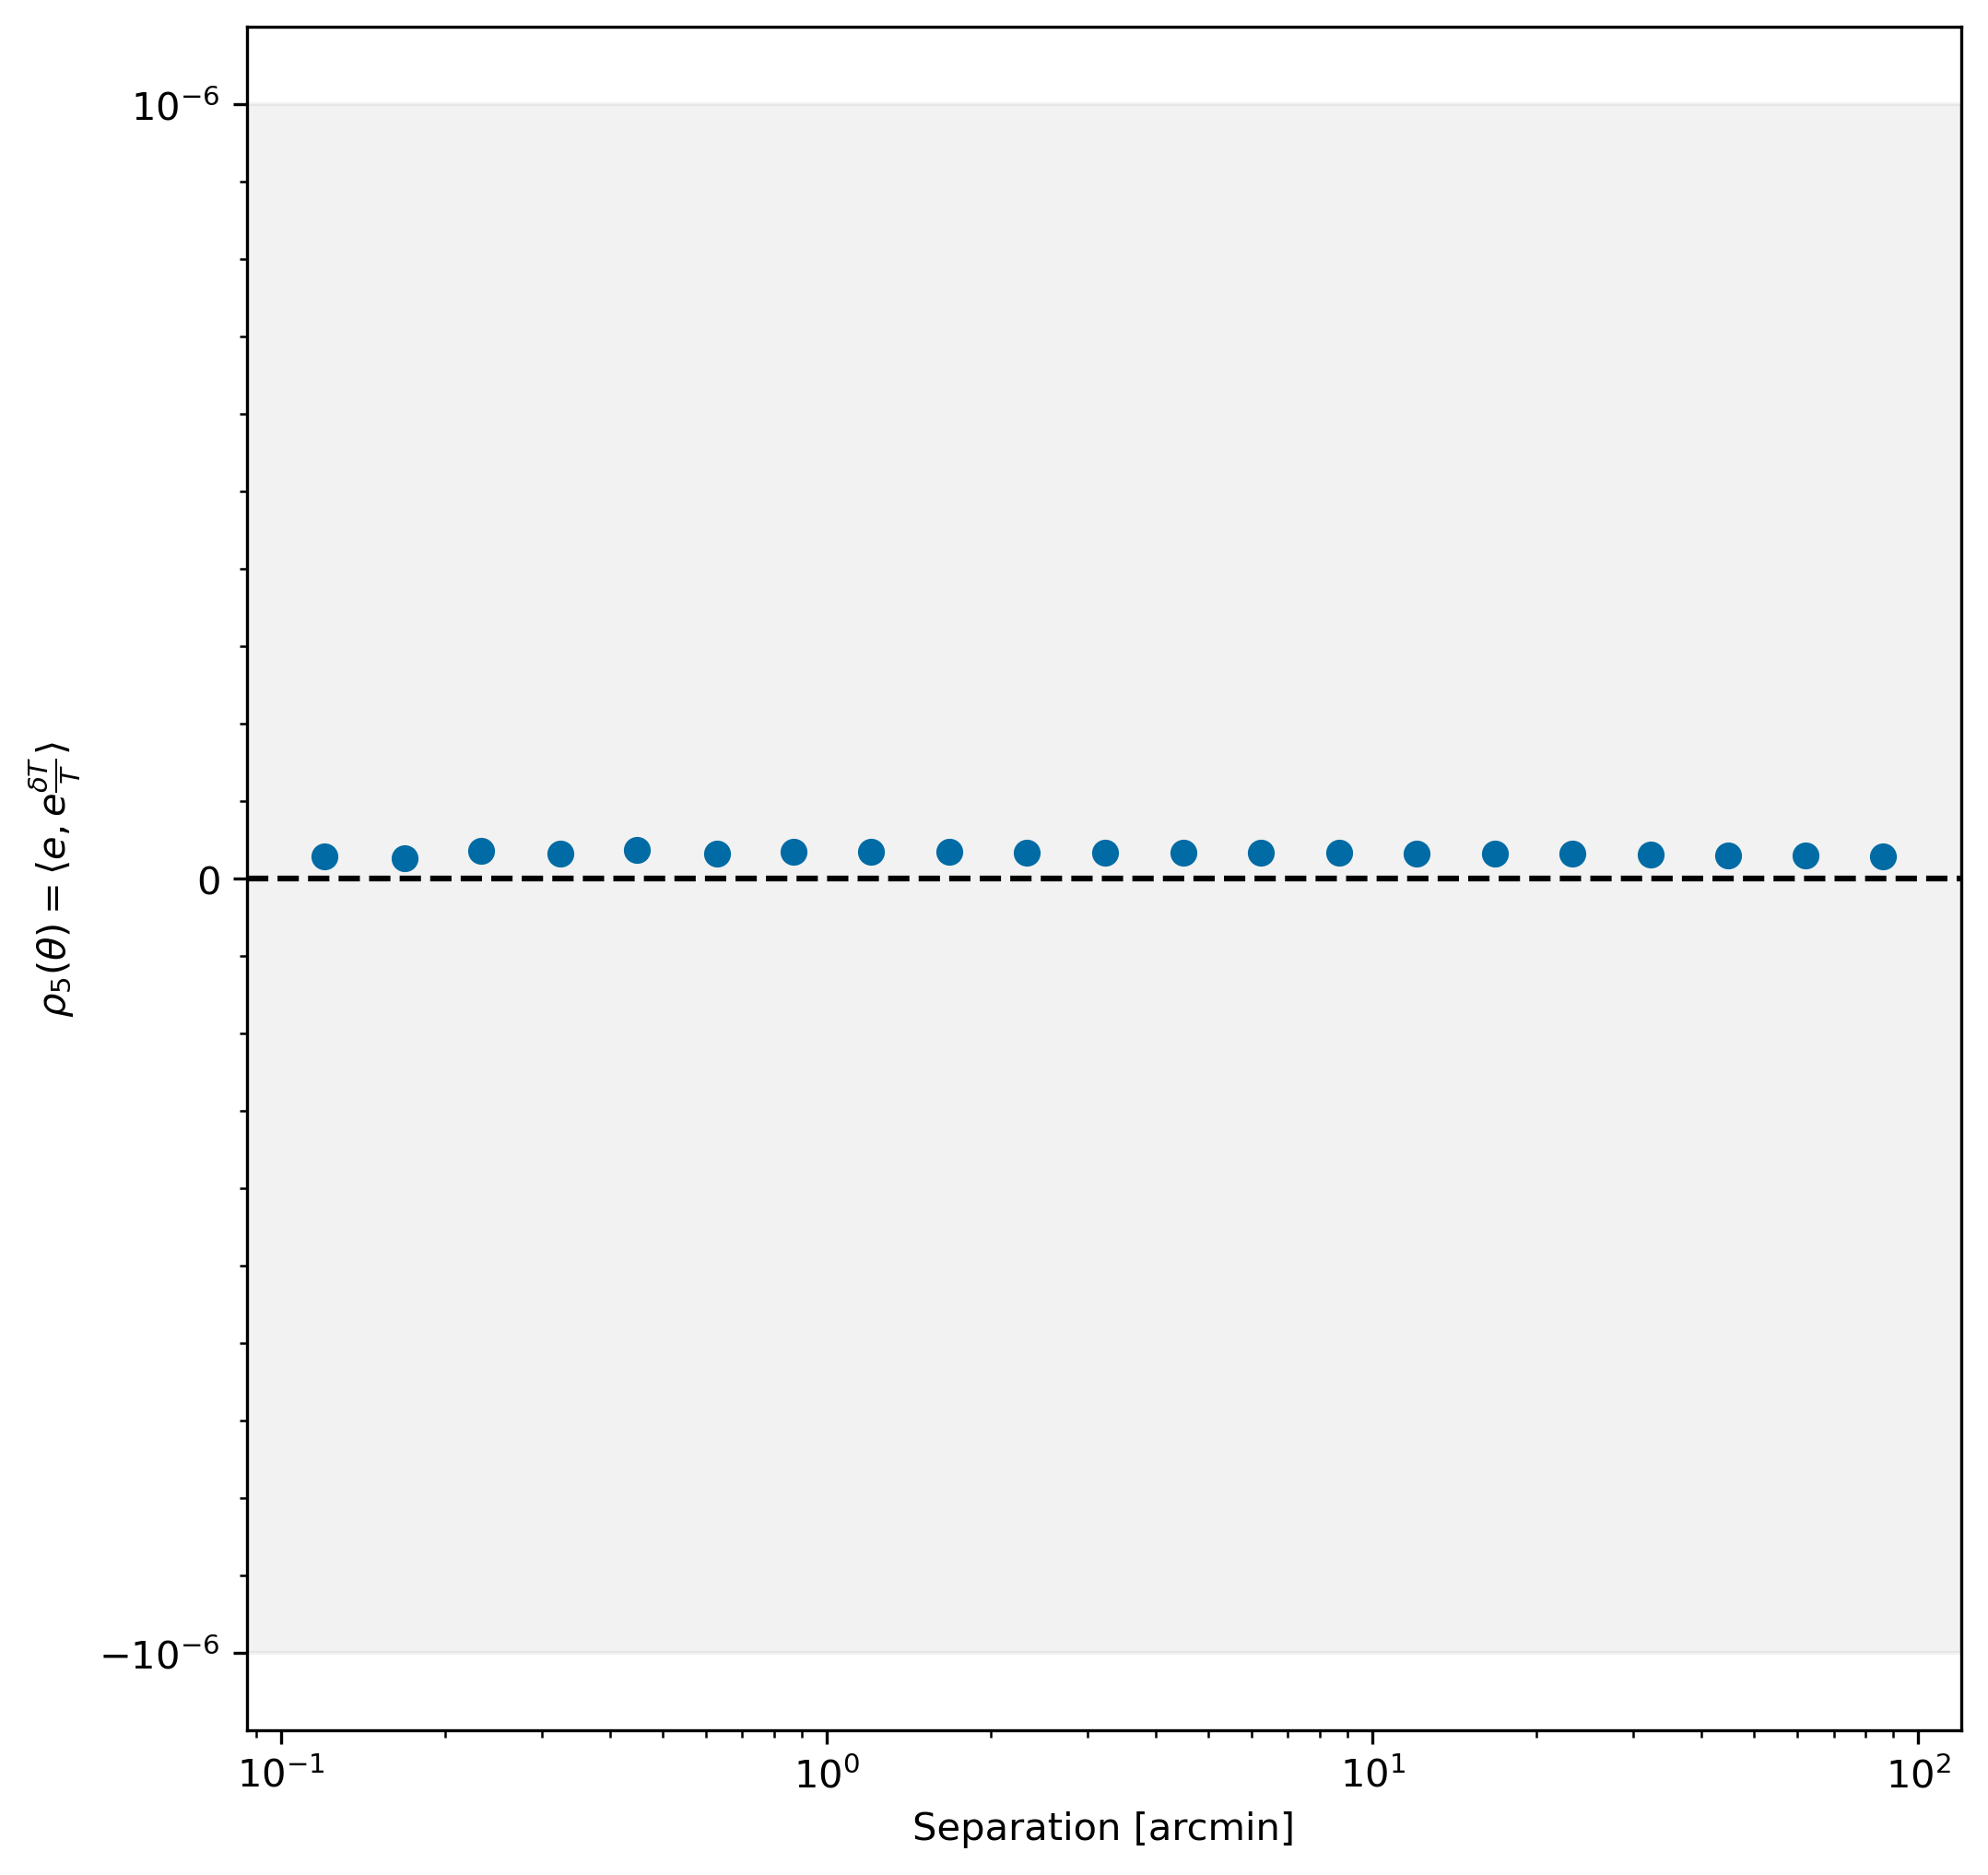

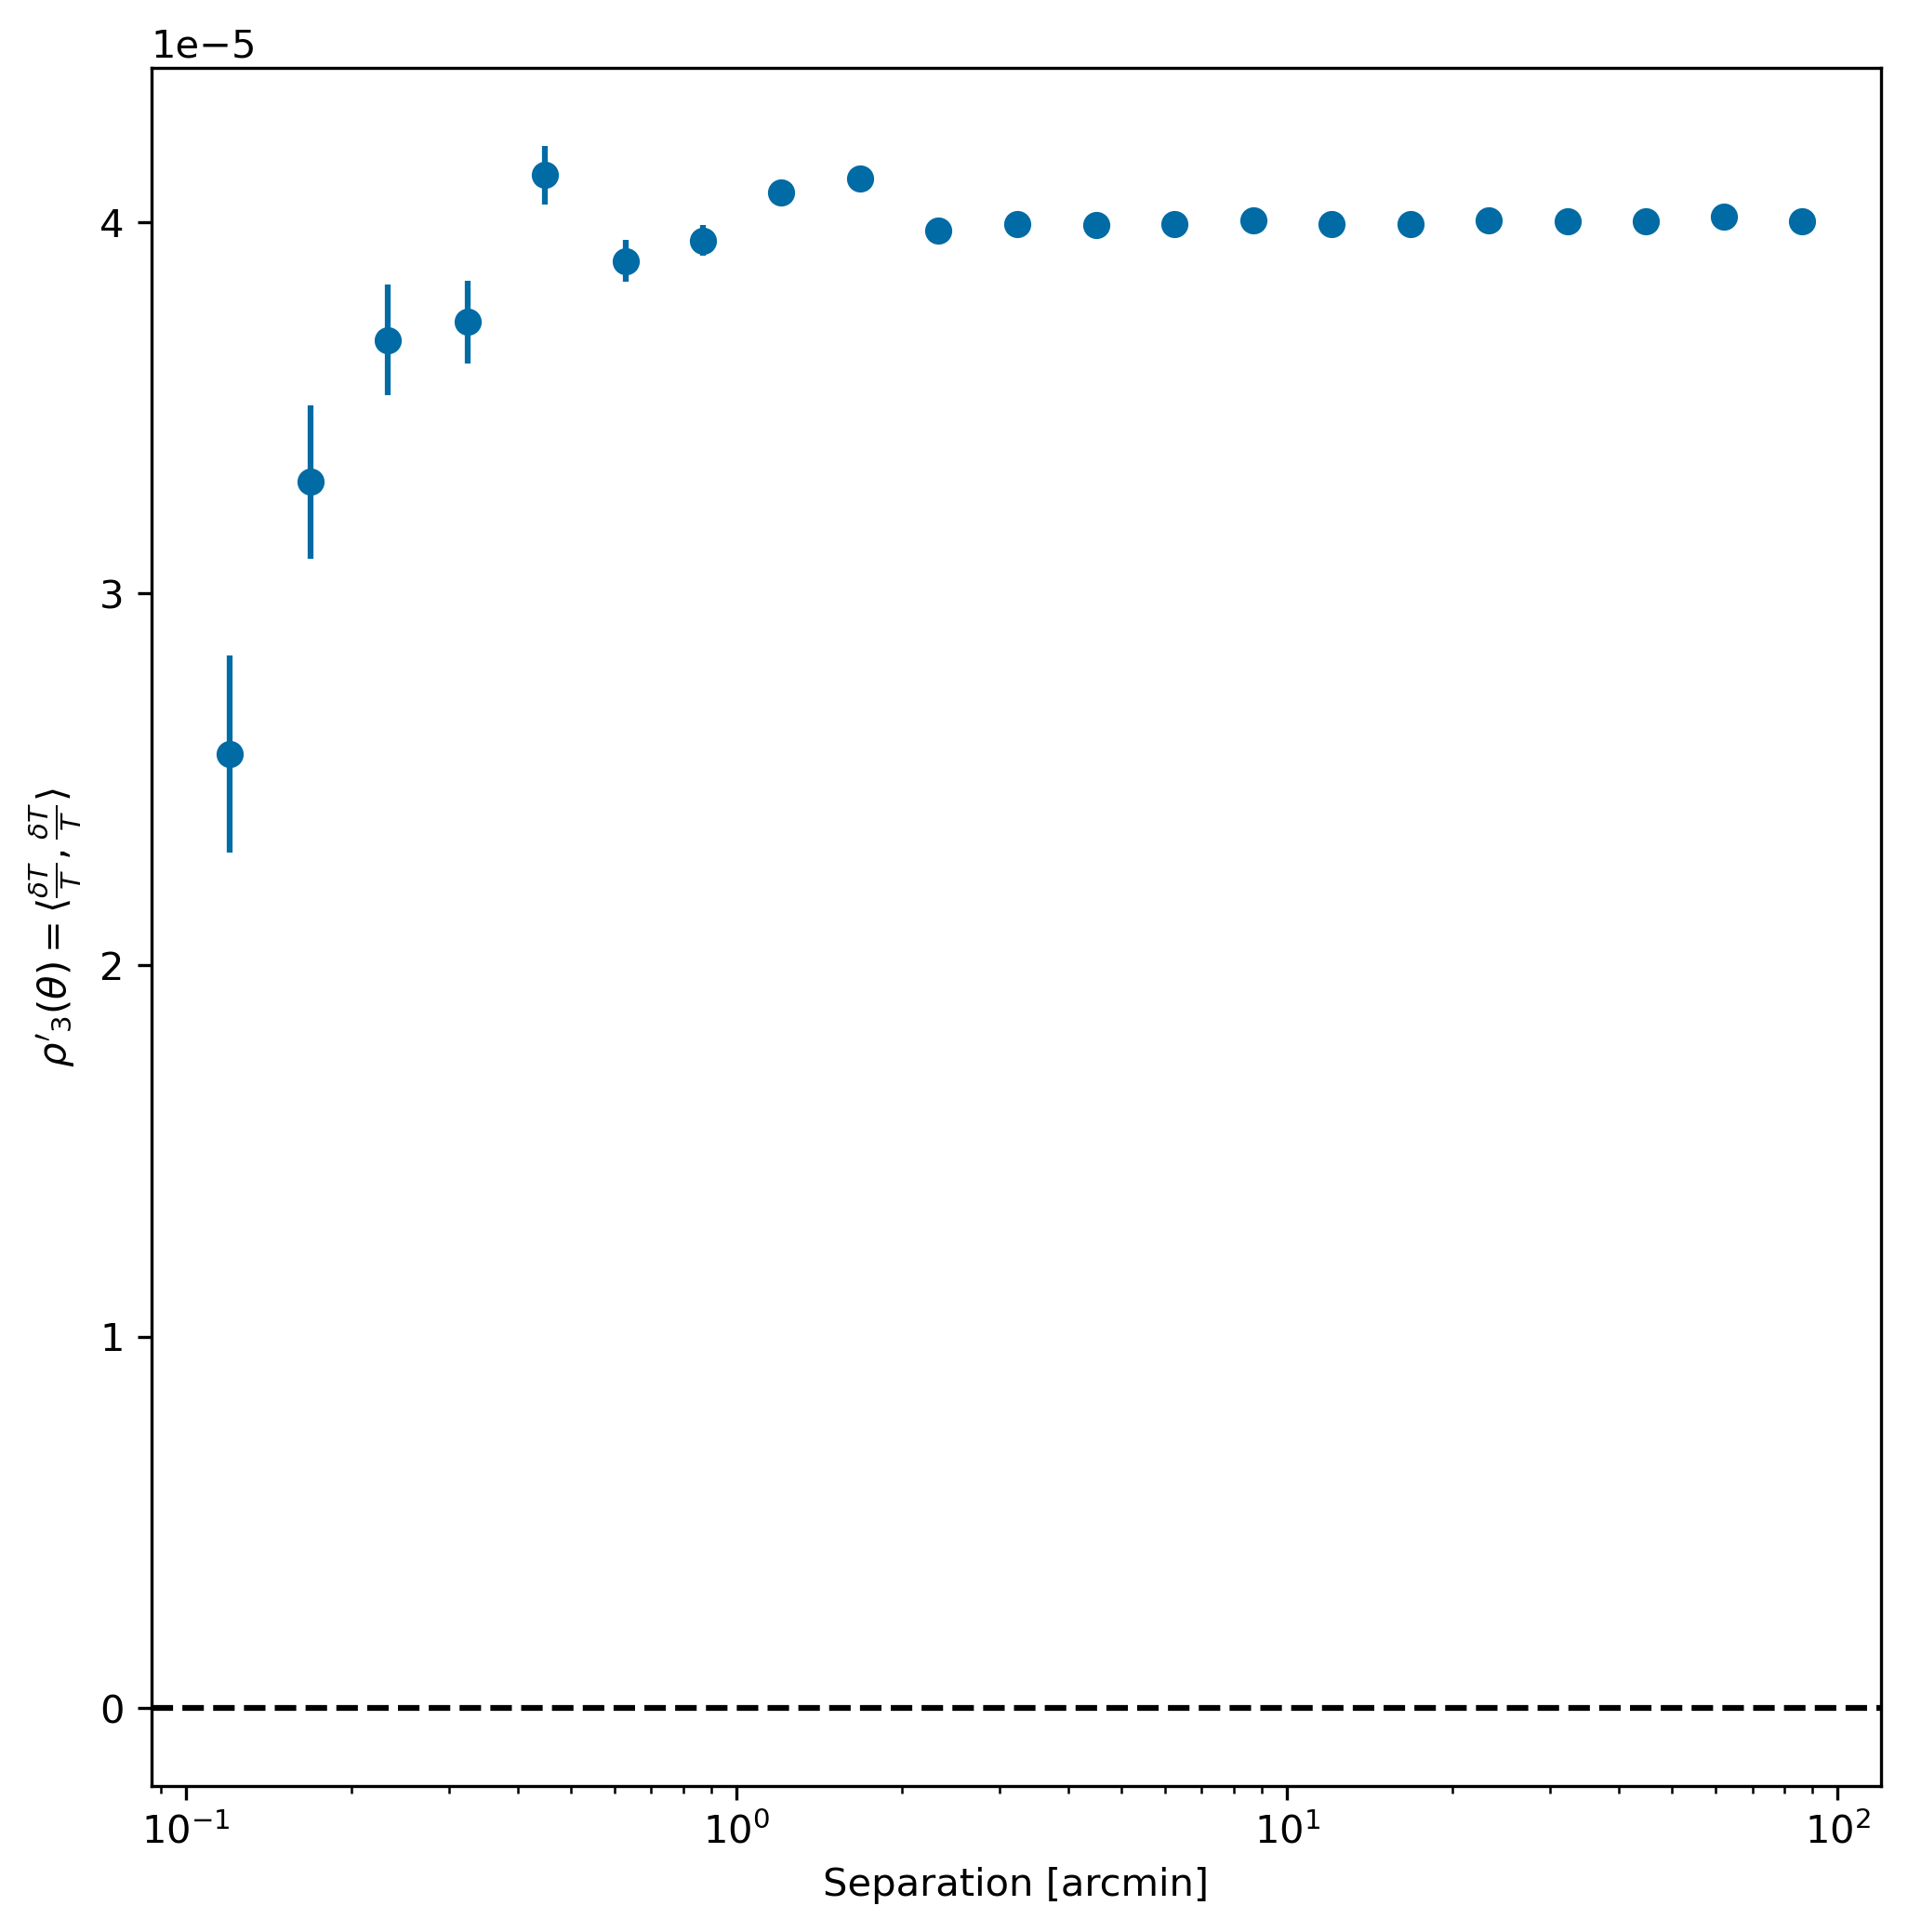

In [33]:
produceResults = atool.produce(processResults, band=f"{band}", skymap=None)

As explained in [Jarvis et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract), `rho1` (ρ1), `rho3` (ρ3), and `rho4` (ρ4) represent direct systematic errors in `xi+` (ξ+) with leading coefficients of order unity. `rho2` (ρ2) and `rho5` (ρ5) describe the extent of "PSF leakage" that occurs during the shear measurement process.

The DC2 area is relatively small and does not exhibit significant PSF variations. The `rho` statistics obtained in the previous examples (for the `i` band, considering that `rho` statistics can vary with different bands) are relatively small and well-behaved. For comparison, you can refer to Figure 26 of the [HSC Y3 shape catalog](https://ui.adsabs.harvard.edu/abs/2022PASJ...74..421L/abstract) and Figure 12 of the [DES Y3 shape catalog analyses](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract), which display `rho` statistics obtained from on-sky data from their respective galaxy surveys (HSC Survey and DES). These figures also include the requirements that each `rho` statistic should satisfy (e.g., Eq. 37 of [Li et al. 2022](https://ui.adsabs.harvard.edu/abs/2022PASJ...74..421L/abstract)) to ensure that there are no significant PSF modeling systematic errors that would impact the scientific goals related to cosmic shear.

### Exercises for the Learner

#### Section 2:
* a) Calculate the PSF ellipticity using the definition based on the second moments, as described in section 7 of [Jarvis et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract). Create plots similar to those in section 3.2 to visualize the PSF ellipticity variation across the image.

* b) Modify the query in section 2.1 to retrieve both point sources and extended sources. Create a size-magnitude diagram using the definition of size from section 2.2. Identify the region in the diagram where the size is constant, representing likely stars during the star-galaxy separation process. Compare your results with Figure 3 in [Jarvis et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract).

#### Section 4: 
* a) Modify the query in section 2.1 to retrieve the required catalog fields according to the input schema for the `RhoStatistics` of `analysis_tools`. Calculate the `rho` statistics for a different band, such as the `g` band. Note that chromatic effects, including Differential Chromatic Refraction (DCR) and wavelength-dependent seeing, have a larger impact in the bluer bands. Use the `rho` statistics as a diagnostic tool to assess whether observations in these bluer bands should be included in weak lensing analyses (refer to the discussion in section 7.4 of [Jarvis et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract)).